<a href="https://colab.research.google.com/github/bstrain71/422_boston_housing/blob/master/Strain_Boston_Housing_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ingest

In [0]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import sklearn
import math
import sklearn.model_selection
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# read data from github
df = pd.read_csv('https://raw.githubusercontent.com/bstrain71/422_boston_housing/master/boston.csv')


# remove neighborhood column IAW instructions
df = df.drop(columns=['neighborhood'])

base_df = df # save this to call column names, etc


## EDA

In [0]:
# i would like to predict the natural log vice the actual values
df['mv'] = np.log(df['mv'])
df = pd.DataFrame(df)

print(df.shape)
df.describe()

(506, 13)


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,3.034558
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,0.408275
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,1.609438
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,2.834680
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,3.054001
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,3.218876
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,3.912023


In [0]:
# preprocess the data - scale everything to zero mean and unit variance
# scale everything but the response variable
no_response = df.drop(columns=['mv'])
df_preprocessing = sklearn.preprocessing.scale(no_response)
df = pd.concat((pd.DataFrame(df_preprocessing),
                pd.DataFrame(df['mv'])),
               axis = 1)

df.columns = list(base_df.columns) 

df.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000
mean,-8.688702e-17,3.306534e-16,2.804081e-16,-3.100287e-16,-8.071058e-16,-5.978968e-17,-2.650493e-16,8.293761e-17,1.514379e-15,-9.934960e-16,4.493551e-16,-1.595123e-16,3.034558
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,0.408275
min,-4.197819e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990e+00,-2.707379e+00,-1.531127e+00,1.609438
25%,-4.109696e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-7.675760e-01,-4.880391e-01,-7.994200e-01,2.834680
50%,-3.906665e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-4.646726e-01,2.748590e-01,-1.812536e-01,3.054001
75%,7.396560e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926e+00,8.065758e-01,6.030188e-01,3.218876
max,9.933931e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194e+00,1.638828e+00,3.548771e+00,3.912023


## Modeling

Goal for this assignment: do a pretty graph comparing the performance of the models. Maybe number of splits, pruning, something cool on x-axis?

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import Ridge

In [0]:
# OLS
X_train, X_test, y_train, y_test = train_test_split(
  df.loc[:,:'lstat'], df.loc[:,'mv'],
    random_state=24601)

# OLS regression
ols = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(ols.score(X_train, y_train)))
print("Test set score: {:.3f}".format(ols.score(X_test, y_test)))

ols_predictions = pd.DataFrame(ols.predict(X_test))

RMSE = sqrt(mean_squared_error(y_test, ols_predictions))
print("RMSE:{:.3f}".format(RMSE))

# Ridge regression with all vars performed well. Let's cross validate this
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ols, df.loc[:,:'lstat'], df['mv'], cv=5)
print("5-Fold Cross Valication Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(),
                                                               scores.std() * 2))

Training set score: 0.793
Test set score: 0.769
RMSE:0.191
5-Fold Cross Valication Accuracy: 0.62 (+/- 0.13)


In [0]:
print(scores)

[0.70622803 0.68690075 0.5879571  0.56053291 0.54200121]


In [0]:
# ridge regression
ridge = Ridge(alpha = 10).fit(X_train, y_train)
print("Training set score: {:.3f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.3f}".format(ridge.score(X_test, y_test)))

ridge_predictions = pd.DataFrame(ridge.predict(X_test))

RMSE = sqrt(mean_squared_error(y_test, ridge_predictions))
print("RMSE:{:.3f}".format(RMSE))

# Ridge regression cross validate
scores = cross_val_score(ridge, df.loc[:,:'lstat'], df['mv'], cv=5)
print("5-Fold Cross Valication Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training set score: 0.792
Test set score: 0.766
RMSE:0.192
5-Fold Cross Valication Accuracy: 0.63 (+/- 0.17)


In [0]:
# random forest
#math.log2(12) is approx 3.5 - round this to 4 for max_features
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor(n_estimators = 100,
                               max_depth = 7,
                               max_features = 4,
                               bootstrap = True,
                               random_state = 24601).fit(X_train,y_train)

#rforest.fit(X_train,y_train)
print("Training set score: {:.3f}".format(rforest.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rforest.score(X_test, y_test)))

rforest_predictions = pd.DataFrame(rforest.predict(X_test))

RMSE = sqrt(mean_squared_error(y_test, rforest_predictions))
print("RMSE:{:.3f}".format(RMSE))

# random forests cross valication
scores = cross_val_score(rforest, df.loc[:,:'lstat'], df['mv'], cv=5)
print("5-Fold Cross Valication Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(),
                                                               scores.std() * 2))
# random forest feature importance
importances = rforest.feature_importances_
indices = np.argsort(importances)[::-1]

for name, score in zip(df, indices):
        print(name, score)


Training set score: 0.963
Test set score: 0.875
RMSE:0.141
5-Fold Cross Valication Accuracy: 0.67 (+/- 0.22)
crim 11
zn 5
indus 0
chas 4
nox 10
rooms 7
age 9
dis 2
rad 6
tax 8
ptratio 3
lstat 1


Feature ranking:
1. feature 11 (0.339002)
2. feature 5 (0.189012)
3. feature 0 (0.171599)
4. feature 4 (0.078084)
5. feature 7 (0.059390)
6. feature 10 (0.058586)
7. feature 9 (0.038832)
8. feature 6 (0.024105)
9. feature 2 (0.023703)
10. feature 8 (0.010244)
11. feature 3 (0.003870)
12. feature 1 (0.003573)


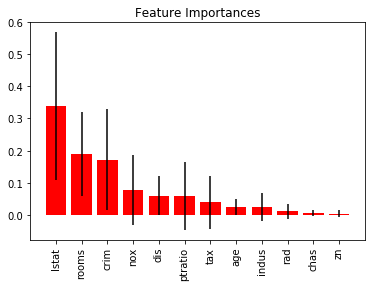

In [0]:
std = np.std([tree.feature_importances_ for tree in rforest.estimators_],
             axis=0)

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), df.columns[indices], rotation = 'vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [0]:
print(gbrt_best)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=33,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

#math.log2(12) approx 3.5 round this to 4
gbrt = GradientBoostingRegressor(n_estimators = 100,
                                 max_depth = 7,
                                 max_features = 4,
                                random_state = 24601).fit(X_train,y_train)

errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

gbrt_best_predictions = pd.DataFrame(gbrt_best.predict(X_test))

print("Training set score: {:.3f}".format(gbrt_best.score(X_train, y_train)))
print("Test set score: {:.3f}".format(gbrt_best.score(X_test, y_test)))

RMSE = sqrt(mean_squared_error(y_test, gbrt_best_predictions))
print("RMSE:{:.3f}".format(RMSE))

# Ridge regression cross validate
scores = cross_val_score(gbrt_best, df.loc[:,:'lstat'], df['mv'], cv=5)
print("5-Fold Cross Valication Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(gbrt_best)

Training set score: 0.975
Test set score: 0.853
RMSE:0.152
5-Fold Cross Valication Accuracy: 0.71 (+/- 0.17)
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=96,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
# random forest feature importance
importances = gbrt_best.feature_importances_
indices = np.argsort(importances)[::-1]
print(indices)
# same indices as rforest feature importance - no need to plot again

[11  5  0  4  7 10  9  6  2  8  3  1]


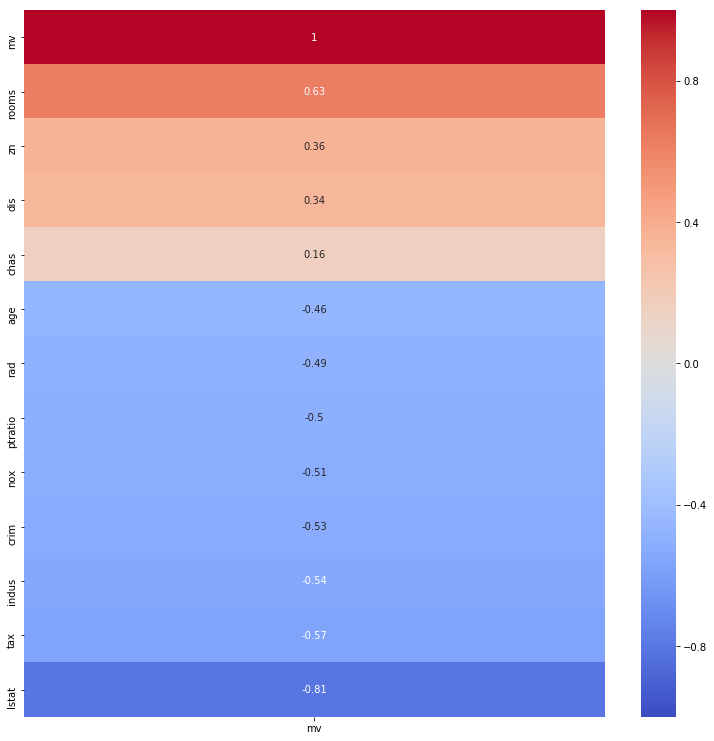

In [0]:
# correlations with mv - the response variable
corr = df.corr()

plt.figure(figsize=(13,13))
sns.heatmap(corr[['mv']].
            sort_values(by=['mv'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

In [0]:
from sklearn.tree import export_graphviz

rforest.fit(X_train,y_train)

export_graphviz(rforest)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

NotFittedError: ignored

## Conclusion